# GameTheory-12 : Jeux a Information Imparfaite et CFR

**Navigation** : [<< 12-ReputationGames](GameTheory-12-ReputationGames.ipynb) | [Index](README.md) | [14-DifferentialGames >>](GameTheory-14-DifferentialGames.ipynb)

## Counterfactual Regret Minimization

Ce notebook couvre les algorithmes de resolution pour les jeux a information imparfaite, notamment la famille CFR (Counterfactual Regret Minimization) qui a revolutionne la resolution du poker.

**Objectifs pedagogiques** :
- Comprendre la difference entre information parfaite et imparfaite
- Maitriser le concept de regret et regret contrefactuel
- Implementer CFR vanilla et ses variantes
- Analyser la convergence vers l'equilibre de Nash

**Prerequis** : Notebooks 1-11 (notamment 7-ExtensiveForm)

**Duree estimee** : 70 minutes

---

## 1. Information Imparfaite : Rappels et Formalisation

### 1.1 Information parfaite vs imparfaite

| Aspect | Parfaite | Imparfaite |
|--------|----------|------------|
| **Definition** | Chaque joueur connait l'historique complet | Certaines actions sont cachees |
| **Information sets** | Singletons | Peuvent contenir plusieurs noeuds |
| **Exemples** | Echecs, Go, Morpion | Poker, Bridge, Bataille navale |
| **Resolution** | Backward induction | CFR, LP sequence-form |

### 1.2 Strategies comportementales vs mixtes

Dans les jeux extensifs a information imparfaite :
- **Strategie comportementale** : probabilite sur les actions a chaque information set
- **Strategie mixte** : probabilite sur les strategies pures

**Theoreme de Kuhn** : Dans les jeux a rappel parfait, strategies comportementales et mixtes sont equivalentes.

In [1]:
# Installation des dependances
import subprocess
import sys

packages = ['numpy', 'matplotlib', 'tqdm']
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

# Tentative d'installation OpenSpiel (peut echouer sur certains systemes)
try:
    import pyspiel
    OPENSPIEL_AVAILABLE = True
except ImportError:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'open_spiel'])
        import pyspiel
        OPENSPIEL_AVAILABLE = True
    except:
        OPENSPIEL_AVAILABLE = False
        print("OpenSpiel non disponible - utilisation des implementations locales")

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
from tqdm import tqdm

print("Imports reussis")
print(f"OpenSpiel disponible: {OPENSPIEL_AVAILABLE}")

Imports reussis
OpenSpiel disponible: True


## 2. Kuhn Poker : Notre Jeu de Reference

Le **Kuhn Poker** est le plus petit jeu de poker interessant :
- 3 cartes : Jack (J), Queen (Q), King (K)
- 2 joueurs, chacun recoit 1 carte
- Mise initiale de 1 (ante)
- Actions : Check/Bet pour J1, puis Fold/Call pour J2

### Arbre de jeu simplifie

```
        [Chance: distribue cartes]
              |
         [J1: Check/Bet]
        /              \
   Check               Bet
      |                  |
  [J2: Check/Bet]    [J2: Fold/Call]
   /      \           /      \
Check    Bet       Fold     Call
  |        |         |        |
Show    [J1]       J1wins   Show
```

**Equilibre de Nash** (connu analytiquement) :
- J1 avec J : bet avec prob 1/3, check sinon
- J1 avec Q : toujours check
- J1 avec K : toujours bet
- J2 : call avec K toujours, call avec Q face a un bet avec prob 1/3

In [2]:
class KuhnPoker:
    """
    Implementation du Kuhn Poker pour CFR.
    
    Cartes: 0=Jack, 1=Queen, 2=King
    Actions: 0=Pass/Fold, 1=Bet/Call
    """
    
    PASS = 0
    BET = 1
    NUM_ACTIONS = 2
    
    def __init__(self):
        self.cards = [0, 1, 2]  # J, Q, K
        
    def is_terminal(self, history: str) -> bool:
        """Verifie si l'historique correspond a un etat terminal."""
        return history in ['pp', 'pbp', 'pbb', 'bp', 'bb']
    
    def get_payoff(self, history: str, cards: List[int]) -> float:
        """
        Retourne le payoff du joueur 1.
        
        cards[0] = carte J1, cards[1] = carte J2
        """
        if history == 'pp':  # check-check: showdown
            return 1 if cards[0] > cards[1] else -1
        elif history == 'pbp':  # check-bet-fold: J2 gagne l'ante
            return -1
        elif history == 'pbb':  # check-bet-call: showdown pour pot=4
            return 2 if cards[0] > cards[1] else -2
        elif history == 'bp':  # bet-fold: J1 gagne l'ante
            return 1
        elif history == 'bb':  # bet-call: showdown pour pot=4
            return 2 if cards[0] > cards[1] else -2
        return 0
    
    def get_info_set(self, history: str, card: int) -> str:
        """Retourne l'information set (carte + historique visible)."""
        card_str = ['J', 'Q', 'K'][card]
        return card_str + history
    
    def get_current_player(self, history: str) -> int:
        """Retourne le joueur courant (0 ou 1)."""
        return len(history) % 2
    
    def get_actions(self, history: str) -> List[int]:
        """Retourne les actions legales."""
        return [0, 1]  # Pass/Fold ou Bet/Call


# Test
kuhn = KuhnPoker()
print("Test Kuhn Poker:")
print(f"  'pp' terminal? {kuhn.is_terminal('pp')}")
print(f"  'p' terminal? {kuhn.is_terminal('p')}")
print(f"  Payoff 'bb' avec K vs J: {kuhn.get_payoff('bb', [2, 0])}")
print(f"  Payoff 'bp' (fold): {kuhn.get_payoff('bp', [0, 2])}")
print(f"  Info set J1 avec Q apres '': {kuhn.get_info_set('', 1)}")

Test Kuhn Poker:
  'pp' terminal? True
  'p' terminal? False
  Payoff 'bb' avec K vs J: 2
  Payoff 'bp' (fold): 1
  Info set J1 avec Q apres '': Q


## 3. Regret et Regret Contrefactuel

### 3.1 Regret classique (Hannan)

Le **regret** pour une action $a$ apres $T$ tours est :

$$R^T(a) = \sum_{t=1}^{T} [u(a, s^t) - u(a^t, s^t)]$$

ou $s^t$ est la strategie adverse au tour $t$ et $a^t$ l'action jouee.

### 3.2 Regret Matching

L'algorithme de **Regret Matching** (Hart & Mas-Colell, 2000) :
1. Calculer le regret cumule $R^T(a)$ pour chaque action
2. Jouer proportionnellement aux regrets positifs :

$$\sigma^{T+1}(a) = \frac{\max(R^T(a), 0)}{\sum_{a'} \max(R^T(a'), 0)}$$

**Theoreme** : Le regret moyen converge vers 0, i.e. $\frac{R^T}{T} \to 0$.

### 3.3 Regret Contrefactuel (CFR)

Pour les jeux extensifs, on utilise le **regret contrefactuel** :

$$r_i(I, a) = v_i(\sigma_{I \to a}) - v_i(\sigma)$$

ou $\sigma_{I \to a}$ est la strategie ou on joue toujours $a$ a l'infoset $I$.

Plus precisement :
$$r_i(I, a) = \sum_{h \in I} \pi_{-i}^\sigma(h) [v_i(\sigma, h \cdot a) - v_i(\sigma, h)]$$

In [3]:
class RegretMatcher:
    """
    Implementation du Regret Matching pour un agent.
    """
    
    def __init__(self, num_actions: int):
        self.num_actions = num_actions
        self.regret_sum = np.zeros(num_actions)
        self.strategy_sum = np.zeros(num_actions)
        
    def get_strategy(self) -> np.ndarray:
        """Calcule la strategie courante via regret matching."""
        positive_regrets = np.maximum(self.regret_sum, 0)
        normalizing_sum = positive_regrets.sum()
        
        if normalizing_sum > 0:
            return positive_regrets / normalizing_sum
        else:
            # Strategie uniforme si pas de regret positif
            return np.ones(self.num_actions) / self.num_actions
    
    def get_average_strategy(self) -> np.ndarray:
        """Retourne la strategie moyenne (converge vers Nash)."""
        normalizing_sum = self.strategy_sum.sum()
        if normalizing_sum > 0:
            return self.strategy_sum / normalizing_sum
        else:
            return np.ones(self.num_actions) / self.num_actions
    
    def update(self, action_utilities: np.ndarray, reach_prob: float = 1.0):
        """
        Met a jour les regrets apres avoir observe les utilites.
        
        action_utilities[a] = utilite de l'action a
        reach_prob = probabilite d'atteindre cet etat
        """
        strategy = self.get_strategy()
        expected_utility = (strategy * action_utilities).sum()
        
        # Regret = utilite action - utilite esperee
        regrets = action_utilities - expected_utility
        self.regret_sum += regrets
        
        # Accumulation de la strategie ponderee
        self.strategy_sum += reach_prob * strategy


# Demonstration : Rock-Paper-Scissors
print("Demo Regret Matching sur Pierre-Feuille-Ciseaux")
print("="*50)

rps_matcher = RegretMatcher(3)  # 0=Rock, 1=Paper, 2=Scissors

# Simuler contre un adversaire qui joue toujours Rock
for t in range(1000):
    opponent_action = 0  # Rock
    # Utilites: Rock=0, Paper=1, Scissors=-1 (contre Rock)
    utilities = np.array([0.0, 1.0, -1.0])
    rps_matcher.update(utilities)

avg_strategy = rps_matcher.get_average_strategy()
print(f"Strategie moyenne apres 1000 iterations:")
print(f"  Rock: {avg_strategy[0]:.3f}, Paper: {avg_strategy[1]:.3f}, Scissors: {avg_strategy[2]:.3f}")
print(f"  -> Converge vers Paper (meilleure reponse a Rock)")

Demo Regret Matching sur Pierre-Feuille-Ciseaux
Strategie moyenne apres 1000 iterations:
  Rock: 0.000, Paper: 0.999, Scissors: 0.000
  -> Converge vers Paper (meilleure reponse a Rock)


## 4. CFR Vanilla : Implementation Complete

L'algorithme CFR (Zinkevich et al., 2007) applique le regret matching a chaque information set d'un jeu extensif.

### Algorithme

```
function CFR(history h, reach_probs pi):
    if h est terminal:
        return payoff(h)
    
    player = current_player(h)
    info_set = get_info_set(h)
    strategy = regret_match(info_set)
    
    action_utilities = []
    for action a in actions(h):
        new_pi = pi.copy()
        new_pi[player] *= strategy[a]
        utility = CFR(h + a, new_pi)
        action_utilities.append(utility)
    
    # Mise a jour des regrets contrefactuels
    cf_reach = product(pi[-player])  # reach prob sans le joueur courant
    for a, u in enumerate(action_utilities):
        regret[info_set][a] += cf_reach * (u[player] - node_utility[player])
    
    return weighted_utility
```

In [4]:
class CFRSolver:
    """
    Solveur CFR vanilla pour Kuhn Poker.
    """
    
    def __init__(self):
        self.game = KuhnPoker()
        self.regret_sum: Dict[str, np.ndarray] = defaultdict(
            lambda: np.zeros(self.game.NUM_ACTIONS)
        )
        self.strategy_sum: Dict[str, np.ndarray] = defaultdict(
            lambda: np.zeros(self.game.NUM_ACTIONS)
        )
        self.iterations = 0
        
    def get_strategy(self, info_set: str) -> np.ndarray:
        """Calcule la strategie courante pour un information set."""
        regrets = self.regret_sum[info_set]
        positive_regrets = np.maximum(regrets, 0)
        normalizing_sum = positive_regrets.sum()
        
        if normalizing_sum > 0:
            return positive_regrets / normalizing_sum
        else:
            return np.ones(self.game.NUM_ACTIONS) / self.game.NUM_ACTIONS
    
    def get_average_strategy(self, info_set: str) -> np.ndarray:
        """Retourne la strategie moyenne pour un information set."""
        strategy_sum = self.strategy_sum[info_set]
        normalizing_sum = strategy_sum.sum()
        
        if normalizing_sum > 0:
            return strategy_sum / normalizing_sum
        else:
            return np.ones(self.game.NUM_ACTIONS) / self.game.NUM_ACTIONS
    
    def cfr(self, history: str, cards: List[int], 
            reach_probs: np.ndarray) -> np.ndarray:
        """
        Recursion CFR principale.
        
        Retourne les utilites esperees pour les deux joueurs.
        """
        # Cas terminal
        if self.game.is_terminal(history):
            payoff = self.game.get_payoff(history, cards)
            return np.array([payoff, -payoff])
        
        player = self.game.get_current_player(history)
        info_set = self.game.get_info_set(history, cards[player])
        strategy = self.get_strategy(info_set)
        
        # Calculer les utilites pour chaque action
        action_utilities = np.zeros((self.game.NUM_ACTIONS, 2))
        node_utility = np.zeros(2)
        
        for action in range(self.game.NUM_ACTIONS):
            action_char = 'p' if action == 0 else 'b'
            new_history = history + action_char
            
            # Mettre a jour les reach probabilities
            new_reach = reach_probs.copy()
            new_reach[player] *= strategy[action]
            
            # Recursion
            action_utilities[action] = self.cfr(new_history, cards, new_reach)
            node_utility += strategy[action] * action_utilities[action]
        
        # Mise a jour des regrets et strategies
        opponent = 1 - player
        cf_reach = reach_probs[opponent]  # Counterfactual reach
        
        for action in range(self.game.NUM_ACTIONS):
            regret = action_utilities[action][player] - node_utility[player]
            self.regret_sum[info_set][action] += cf_reach * regret
        
        # Accumuler la strategie
        self.strategy_sum[info_set] += reach_probs[player] * strategy
        
        return node_utility
    
    def train(self, iterations: int, verbose: bool = True) -> List[float]:
        """
        Entraine le solveur CFR.
        
        Retourne l'historique des utilites esperees.
        """
        utilities = []
        cards_permutations = [
            [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1]
        ]
        
        iterator = tqdm(range(iterations)) if verbose else range(iterations)
        
        for i in iterator:
            total_utility = 0.0
            
            for cards in cards_permutations:
                utility = self.cfr('', cards, np.ones(2))
                total_utility += utility[0]
            
            # Utilite moyenne sur toutes les distributions de cartes
            avg_utility = total_utility / len(cards_permutations)
            utilities.append(avg_utility)
            self.iterations += 1
        
        return utilities
    
    def get_exploitability(self) -> float:
        """
        Calcule l'exploitabilite de la strategie courante.
        
        Plus la valeur est basse, plus on est proche de Nash.
        """
        # Simplification: on retourne la variance des regrets
        total_positive_regret = 0.0
        for info_set in self.regret_sum:
            total_positive_regret += np.maximum(self.regret_sum[info_set], 0).sum()
        return total_positive_regret / max(1, self.iterations)


print("CFRSolver defini avec succes")

CFRSolver defini avec succes


In [5]:
# Entrainement CFR
print("Entrainement CFR sur Kuhn Poker")
print("="*50)

cfr_solver = CFRSolver()
utilities = cfr_solver.train(iterations=10000, verbose=True)

print(f"\nIterations: {cfr_solver.iterations}")
print(f"Utilite finale J1: {utilities[-1]:.4f}")
print(f"Exploitabilite: {cfr_solver.get_exploitability():.6f}")

Entrainement CFR sur Kuhn Poker


100%|██████████| 10000/10000 [00:01<00:00, 5639.82it/s]


Iterations: 10000
Utilite finale J1: -0.0334
Exploitabilite: 0.044653


In [6]:
# Affichage des strategies apprises
print("\nStrategies moyennes apprises:")
print("="*50)

# Equilibre theorique pour comparaison
theoretical = {
    'J': (1/3, 2/3),   # Bet 1/3, Pass 2/3
    'Q': (0.0, 1.0),   # Toujours Pass
    'K': (1.0, 0.0),   # Toujours Bet
    'Jp': (1/3, 2/3),  # Apres check adverse, bet 1/3 (bluff)
    'Qp': (0.0, 1.0),  # Apres check, toujours pass
    'Kp': (1.0, 0.0),  # Apres check, toujours bet (value)
    'Jpb': (0.0, 1.0), # Face a bet, fold avec J
    'Qpb': (1/3, 2/3), # Face a bet, call 1/3 avec Q
    'Kpb': (1.0, 0.0), # Face a bet, toujours call avec K
    'Jb': (0.0, 1.0),  # Face a bet initial, fold avec J
    'Qb': (1/3, 2/3),  # Face a bet, call 1/3
    'Kb': (1.0, 0.0),  # Face a bet, call avec K
}

info_sets_to_show = ['J', 'Q', 'K', 'Jb', 'Qb', 'Kb']

print(f"{'Info Set':<10} {'Appris (b/p)':<20} {'Theorique (b/p)':<20}")
print("-"*50)

for info_set in info_sets_to_show:
    if info_set in cfr_solver.strategy_sum:
        learned = cfr_solver.get_average_strategy(info_set)
        theo = theoretical.get(info_set, (0.5, 0.5))
        # Note: action 0=pass, action 1=bet
        print(f"{info_set:<10} ({learned[1]:.3f}/{learned[0]:.3f})         ({theo[0]:.3f}/{theo[1]:.3f})")


Strategies moyennes apprises:
Info Set   Appris (b/p)         Theorique (b/p)     
--------------------------------------------------
J          (0.216/0.784)         (0.333/0.667)
Q          (0.000/1.000)         (0.000/1.000)
K          (0.668/0.332)         (1.000/0.000)
Jb         (0.000/1.000)         (0.000/1.000)
Qb         (0.337/0.663)         (0.333/0.667)
Kb         (1.000/0.000)         (1.000/0.000)


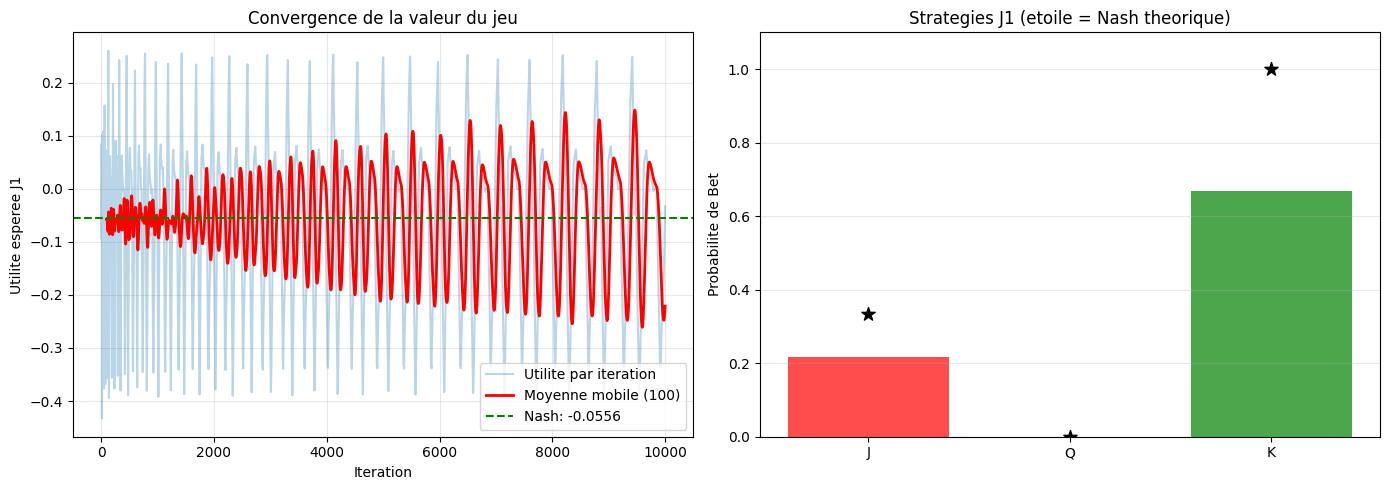


Figure sauvegardee: cfr_convergence.png


In [7]:
# Visualisation de la convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Utilite esperee
ax1 = axes[0]
ax1.plot(utilities, alpha=0.3, label='Utilite par iteration')
# Moyenne mobile
window = 100
if len(utilities) > window:
    moving_avg = np.convolve(utilities, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(utilities)), moving_avg, 'r-', linewidth=2,
             label=f'Moyenne mobile ({window})')

# Valeur theorique du jeu pour J1: -1/18
ax1.axhline(y=-1/18, color='g', linestyle='--', label=f'Nash: {-1/18:.4f}')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Utilite esperee J1')
ax1.set_title('Convergence de la valeur du jeu')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Evolution des strategies pour J1 avec Jack (doit converger vers bet=1/3)
ax2 = axes[1]
# Recalculer l'historique des strategies (simplification: on montre l'etat final)
info_sets = ['J', 'Q', 'K']
colors = ['red', 'blue', 'green']
theo_values = [1/3, 0.0, 1.0]  # Prob de bet

for i, (info_set, color, theo) in enumerate(zip(info_sets, colors, theo_values)):
    if info_set in cfr_solver.strategy_sum:
        learned_bet = cfr_solver.get_average_strategy(info_set)[1]
        ax2.bar(i, learned_bet, color=color, alpha=0.7, label=f'{info_set} appris')
        ax2.scatter(i, theo, color='black', s=100, marker='*', zorder=5)

ax2.set_xticks(range(len(info_sets)))
ax2.set_xticklabels(info_sets)
ax2.set_ylabel('Probabilite de Bet')
ax2.set_title('Strategies J1 (etoile = Nash theorique)')
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cfr_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure sauvegardee: cfr_convergence.png")

## 5. Variantes de CFR

### 5.1 CFR+ (Tammelin, 2014)

Amelioration de CFR avec :
- **Regrets non-negatifs** : $R^{T+1} = \max(R^T + r^t, 0)$
- Convergence plus rapide en pratique

### 5.2 Monte Carlo CFR (MCCFR)

Au lieu de parcourir tout l'arbre, on echantillonne :
- **Outcome Sampling** : echantillonne une trajectoire complete
- **External Sampling** : echantillonne les actions des adversaires
- **Chance Sampling** : echantillonne les noeuds de chance

### 5.3 Deep CFR (Brown et al., 2019)

Utilise des reseaux de neurones pour :
- Approximer les regrets cumules
- Approximer la strategie moyenne
- Permet de passer a l'echelle (Texas Hold'em)

In [8]:
class CFRPlusSolver(CFRSolver):
    """
    CFR+ : variante avec regrets toujours non-negatifs.
    """
    
    def cfr(self, history: str, cards: List[int], 
            reach_probs: np.ndarray) -> np.ndarray:
        """
        CFR+ avec regrets floors a zero.
        """
        if self.game.is_terminal(history):
            payoff = self.game.get_payoff(history, cards)
            return np.array([payoff, -payoff])
        
        player = self.game.get_current_player(history)
        info_set = self.game.get_info_set(history, cards[player])
        strategy = self.get_strategy(info_set)
        
        action_utilities = np.zeros((self.game.NUM_ACTIONS, 2))
        node_utility = np.zeros(2)
        
        for action in range(self.game.NUM_ACTIONS):
            action_char = 'p' if action == 0 else 'b'
            new_history = history + action_char
            new_reach = reach_probs.copy()
            new_reach[player] *= strategy[action]
            action_utilities[action] = self.cfr(new_history, cards, new_reach)
            node_utility += strategy[action] * action_utilities[action]
        
        opponent = 1 - player
        cf_reach = reach_probs[opponent]
        
        for action in range(self.game.NUM_ACTIONS):
            regret = action_utilities[action][player] - node_utility[player]
            # CFR+ : floor les regrets a zero
            self.regret_sum[info_set][action] = max(
                self.regret_sum[info_set][action] + cf_reach * regret, 0
            )
        
        self.strategy_sum[info_set] += reach_probs[player] * strategy
        return node_utility


# Comparaison CFR vs CFR+
print("Comparaison CFR vs CFR+")
print("="*50)

cfr_vanilla = CFRSolver()
cfr_plus = CFRPlusSolver()

n_iterations = 5000

print("\nEntrainement CFR vanilla...")
utilities_vanilla = cfr_vanilla.train(n_iterations, verbose=False)

print("Entrainement CFR+...")
utilities_plus = cfr_plus.train(n_iterations, verbose=False)

# Comparaison
print(f"\nResultats apres {n_iterations} iterations:")
print(f"  CFR:  utilite finale = {utilities_vanilla[-1]:.4f}, exploitabilite = {cfr_vanilla.get_exploitability():.6f}")
print(f"  CFR+: utilite finale = {utilities_plus[-1]:.4f}, exploitabilite = {cfr_plus.get_exploitability():.6f}")

Comparaison CFR vs CFR+

Entrainement CFR vanilla...
Entrainement CFR+...

Resultats apres 5000 iterations:
  CFR:  utilite finale = 0.2450, exploitabilite = 0.058861
  CFR+: utilite finale = -0.0677, exploitabilite = 0.082403


In [9]:
class MCCFRSolver(CFRSolver):
    """
    Monte Carlo CFR avec external sampling.
    
    Echantillonne les actions de l'adversaire au lieu de
    parcourir tout l'arbre.
    """
    
    def __init__(self, exploring_player: int = 0):
        super().__init__()
        self.exploring_player = exploring_player
    
    def mccfr(self, history: str, cards: List[int], 
              player: int) -> float:
        """
        MCCFR avec external sampling.
        
        Retourne l'utilite pour le joueur specifie.
        """
        if self.game.is_terminal(history):
            payoff = self.game.get_payoff(history, cards)
            return payoff if player == 0 else -payoff
        
        current_player = self.game.get_current_player(history)
        info_set = self.game.get_info_set(history, cards[current_player])
        strategy = self.get_strategy(info_set)
        
        if current_player == player:
            # C'est notre tour: calculer toutes les actions
            action_utilities = np.zeros(self.game.NUM_ACTIONS)
            
            for action in range(self.game.NUM_ACTIONS):
                action_char = 'p' if action == 0 else 'b'
                new_history = history + action_char
                action_utilities[action] = self.mccfr(new_history, cards, player)
            
            node_utility = (strategy * action_utilities).sum()
            
            # Mise a jour des regrets
            for action in range(self.game.NUM_ACTIONS):
                regret = action_utilities[action] - node_utility
                self.regret_sum[info_set][action] += regret
            
            return node_utility
        else:
            # Tour de l'adversaire: echantillonner une action
            action = np.random.choice(self.game.NUM_ACTIONS, p=strategy)
            action_char = 'p' if action == 0 else 'b'
            new_history = history + action_char
            
            # Accumuler la strategie
            self.strategy_sum[info_set] += strategy
            
            return self.mccfr(new_history, cards, player)
    
    def train(self, iterations: int, verbose: bool = True) -> List[float]:
        """Entrainement MCCFR."""
        utilities = []
        cards_permutations = [
            [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1]
        ]
        
        iterator = tqdm(range(iterations)) if verbose else range(iterations)
        
        for i in iterator:
            # Echantillonner une distribution de cartes
            cards = cards_permutations[np.random.randint(len(cards_permutations))]
            
            # Alterner le joueur qui explore
            for player in [0, 1]:
                self.mccfr('', cards, player)
            
            self.iterations += 1
            
            # Calculer l'utilite moyenne periodiquement
            if i % 100 == 0:
                total_utility = 0.0
                for cards in cards_permutations:
                    payoff = self._compute_expected_utility('', cards)
                    total_utility += payoff
                utilities.append(total_utility / len(cards_permutations))
        
        return utilities
    
    def _compute_expected_utility(self, history: str, cards: List[int]) -> float:
        """Calcule l'utilite esperee avec les strategies moyennes."""
        if self.game.is_terminal(history):
            return self.game.get_payoff(history, cards)
        
        player = self.game.get_current_player(history)
        info_set = self.game.get_info_set(history, cards[player])
        strategy = self.get_average_strategy(info_set)
        
        utility = 0.0
        for action in range(self.game.NUM_ACTIONS):
            action_char = 'p' if action == 0 else 'b'
            utility += strategy[action] * self._compute_expected_utility(
                history + action_char, cards
            )
        return utility


print("\nEntrainement MCCFR...")
mccfr = MCCFRSolver()
utilities_mccfr = mccfr.train(50000, verbose=True)

print(f"\nMCCFR apres 50000 iterations:")
print(f"  Utilite finale: {utilities_mccfr[-1]:.4f}")


Entrainement MCCFR...


100%|██████████| 50000/50000 [00:04<00:00, 11220.28it/s]


MCCFR apres 50000 iterations:
  Utilite finale: -0.0554


## 6. OpenSpiel : CFR a l'Echelle

OpenSpiel fournit des implementations optimisees de CFR et ses variantes. Voyons comment les utiliser.

In [10]:
if OPENSPIEL_AVAILABLE:
    from open_spiel.python.algorithms import cfr as openspiel_cfr
    from open_spiel.python.algorithms import exploitability

    # Charger Kuhn Poker
    game = pyspiel.load_game("kuhn_poker")
    print(f"Jeu: {game.get_type().short_name}")
    print(f"Joueurs: {game.num_players()}")
    print(f"Actions max: {game.num_distinct_actions()}")

    # CFR solver OpenSpiel
    cfr_solver_os = openspiel_cfr.CFRSolver(game)

    exploitabilities = []
    iterations_to_record = [1, 10, 100, 500, 1000, 2000, 5000, 10000]

    print("\nEntrainement CFR OpenSpiel...")
    for i in tqdm(range(10001)):
        cfr_solver_os.evaluate_and_update_policy()

        if i in iterations_to_record:
            avg_policy = cfr_solver_os.average_policy()
            expl = exploitability.exploitability(game, avg_policy)
            exploitabilities.append((i, expl))

    print("\nConvergence de l'exploitabilite:")
    print(f"{'Iterations':<12} {'Exploitabilite':<15}")
    print("-"*27)
    for it, expl in exploitabilities:
        print(f"{it:<12} {expl:<15.6f}")

    # Afficher la politique finale
    avg_policy = cfr_solver_os.average_policy()
    print("\nPolitique moyenne finale (premiers info sets):")

    # L'API TabularPolicy n'a plus d'attribut .policy
    # On utilise action_probabilities pour chaque etat
    state = game.new_initial_state()
    
    # Parcourir quelques etats pour montrer les strategies
    def show_policy_for_states(state, policy, depth=0, max_states=6):
        shown = [0]
        def _traverse(s, d):
            if shown[0] >= max_states:
                return
            if s.is_terminal():
                return
            if s.is_chance_node():
                for action, prob in s.chance_outcomes():
                    _traverse(s.child(action), d + 1)
            else:
                info_state = s.information_state_string()
                action_probs = policy.action_probabilities(s)
                if action_probs:
                    print(f"  {info_state}: {dict(action_probs)}")
                    shown[0] += 1
                for action in s.legal_actions():
                    _traverse(s.child(action), d + 1)
        _traverse(state, depth)
    
    show_policy_for_states(game.new_initial_state(), avg_policy)
else:
    print("OpenSpiel non disponible - section ignoree")
    print("Pour installer: pip install open_spiel")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
Jeu: kuhn_poker
Joueurs: 2
Actions max: 2

Entrainement CFR OpenSpiel...


100%|██████████| 10001/10001 [00:05<00:00, 1932.44it/s]


Convergence de l'exploitabilite:
Iterations   Exploitabilite 
---------------------------
1            0.270833       
10           0.060469       
100          0.007681       
500          0.001203       
1000         0.000970       
2000         0.000529       
5000         0.000181       
10000        0.000112       

Politique moyenne finale (premiers info sets):
  0: {0: np.float64(0.7978066566984781), 1: np.float64(0.20219334330152194)}
  1p: {0: np.float64(0.9996500349965004), 1: np.float64(0.00034996500349965005)}
  0pb: {0: np.float64(0.9999686672202593), 1: np.float64(3.1332779740671625e-05)}
  1b: {0: np.float64(0.6662872715819159), 1: np.float64(0.333712728418084)}
  0: {0: np.float64(0.7978066566984781), 1: np.float64(0.20219334330152194)}
  2p: {0: np.float64(9.999000099990002e-05), 1: np.float64(0.9999000099990001)}


Comparaison des variantes CFR (OpenSpiel)

Entrainement CFR...


100%|██████████| 5001/5001 [00:02<00:00, 1888.31it/s]



Entrainement CFR+...


100%|██████████| 5001/5001 [00:02<00:00, 1926.77it/s]


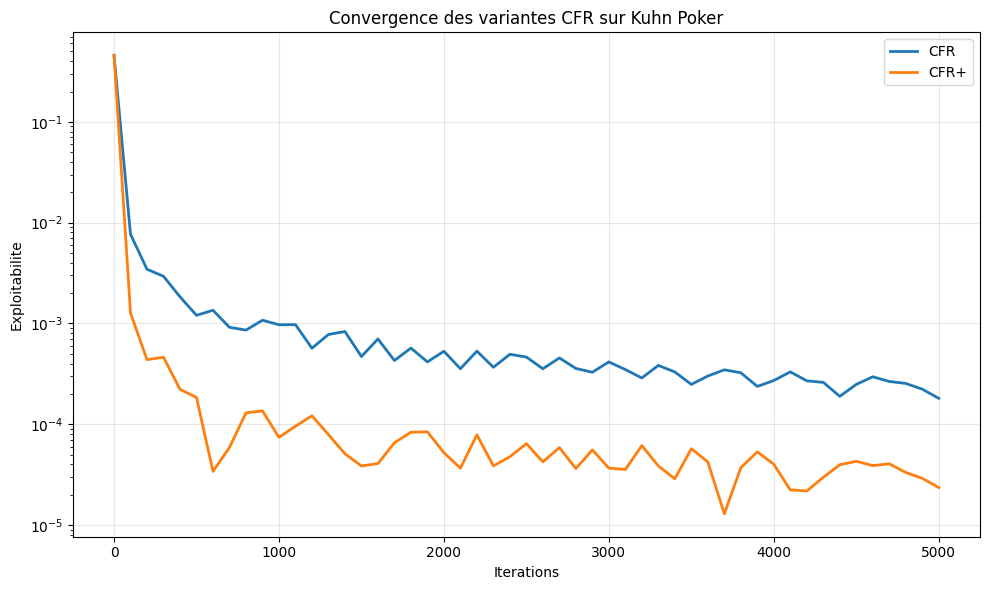


Exploitabilite finale:
  CFR: 0.000181
  CFR+: 0.000023


In [11]:
if OPENSPIEL_AVAILABLE:
    # Comparaison CFR vs CFR+ vs Linear CFR sur OpenSpiel
    from open_spiel.python.algorithms import cfr as cfr_module
    
    game = pyspiel.load_game("kuhn_poker")
    
    solvers = {
        'CFR': cfr_module.CFRSolver(game),
        'CFR+': cfr_module.CFRPlusSolver(game),
    }
    
    results = {name: [] for name in solvers}
    checkpoints = list(range(0, 5001, 100))
    
    print("Comparaison des variantes CFR (OpenSpiel)")
    print("="*50)
    
    for name, solver in solvers.items():
        print(f"\nEntrainement {name}...")
        for i in tqdm(range(5001)):
            solver.evaluate_and_update_policy()
            
            if i in checkpoints:
                avg_policy = solver.average_policy()
                expl = exploitability.exploitability(game, avg_policy)
                results[name].append(expl)
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    for name, expls in results.items():
        plt.plot(checkpoints, expls, label=name, linewidth=2)
    
    plt.xlabel('Iterations')
    plt.ylabel('Exploitabilite')
    plt.title('Convergence des variantes CFR sur Kuhn Poker')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('cfr_variants_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nExploitabilite finale:")
    for name, expls in results.items():
        print(f"  {name}: {expls[-1]:.6f}")

## 7. Leduc Poker : Un Jeu Plus Complexe

Le **Leduc Poker** est un jeu plus riche que Kuhn :
- 6 cartes : 2x Jack, 2x Queen, 2x King
- 2 tours de mises
- Carte commune revelee au 2e tour

Avec ~936 information sets, c'est un bon benchmark intermediaire.

In [12]:
if OPENSPIEL_AVAILABLE:
    from open_spiel.python.algorithms import cfr as cfr_module
    from open_spiel.python.algorithms import exploitability

    # Leduc Poker
    leduc = pyspiel.load_game("leduc_poker")

    print("Leduc Poker")
    print("="*50)
    print(f"Joueurs: {leduc.num_players()}")
    print(f"Actions: {leduc.num_distinct_actions()}")

    # Compter les information sets
    cfr_leduc = cfr_module.CFRSolver(leduc)

    print("\nEntrainement CFR sur Leduc (100 iterations)...")
    for i in tqdm(range(101)):
        cfr_leduc.evaluate_and_update_policy()

    avg_policy = cfr_leduc.average_policy()
    expl = exploitability.exploitability(leduc, avg_policy)

    print(f"\nExploitabilite apres 100 iterations: {expl:.4f}")
    print(f"(Equilibre parfait = 0)")

    # Continuer l'entrainement
    print("\nEntrainement supplementaire (900 iterations)...")
    for i in tqdm(range(900)):
        cfr_leduc.evaluate_and_update_policy()

    avg_policy = cfr_leduc.average_policy()
    expl = exploitability.exploitability(leduc, avg_policy)
    print(f"Exploitabilite apres 1000 iterations: {expl:.4f}")
else:
    print("OpenSpiel requis pour Leduc Poker")

Leduc Poker
Joueurs: 2
Actions: 3

Entrainement CFR sur Leduc (100 iterations)...


100%|██████████| 101/101 [00:07<00:00, 13.04it/s]



Exploitabilite apres 100 iterations: 0.0939
(Equilibre parfait = 0)

Entrainement supplementaire (900 iterations)...


100%|██████████| 900/900 [01:17<00:00, 11.56it/s]


Exploitabilite apres 1000 iterations: 0.0118


## 8. Deep CFR : Apercu

Pour les jeux de grande taille (Texas Hold'em: ~10^14 etats), CFR tabulaire est impossible. **Deep CFR** utilise des reseaux de neurones.

### Architecture

1. **Reseau de regrets** $V_i(I, a; \theta)$ : predit les regrets cumules
2. **Reseau de strategie** $\Pi(I, a; \phi)$ : predit la strategie moyenne
3. **Reservoir sampling** : maintient un echantillon des donnees d'entrainement

### Algorithme simplifie

```
for t = 1 to T:
    # Traversee CFR externe
    for each sampled state h:
        compute counterfactual regrets r(I, a)
        add (I, r) to advantage memory M_V
        add (I, sigma) to strategy memory M_Pi
    
    # Entrainement des reseaux
    train V on M_V (regression)
    train Pi on M_Pi (cross-entropy)
```

### Resultats notables

- **Libratus** (2017) : a battu des pros au Heads-Up No-Limit Hold'em
- **Pluribus** (2019) : premier bot a battre des pros en 6-joueurs

L'implementation complete de Deep CFR depasse le cadre de ce notebook (voir OpenSpiel ou le papier original).

In [ ]:
# Schema conceptuel de Deep CFR
print("Architecture Deep CFR (conceptuel)")
print("="*50)

# Utilisation d'un raw string pour eviter les warnings d'escape sequences
deep_cfr_schema = r"""
+-------------------+     +-------------------+
|   Traversee CFR   |     |   Traversee CFR   |
|   (External       |     |   (External       |
|    Sampling)      |     |    Sampling)      |
+--------+----------+     +--------+----------+
         |                         |
         v                         v
+--------+----------+     +--------+----------+
|  Advantage Memory |     |  Strategy Memory  |
|  M_V: (I, r(I,a)) |     |  M_Pi: (I, sigma) |
+--------+----------+     +--------+----------+
         |                         |
         v                         v
+--------+----------+     +--------+----------+
|   Value Network   |     | Strategy Network  |
|   V(I,a; theta)   |     |  Pi(I,a; phi)     |
|   (MSE loss)      |     | (Cross-entropy)   |
+-------------------+     +-------------------+

         ||                        ||
         \/                        \/
    Regret Matching           Average Strategy
    pour actions              (converge vers Nash)
"""

print(deep_cfr_schema)

print("\nAvantages de Deep CFR:")
print("  - Generalisation: apprend des patterns, pas une table")
print("  - Passage a l'echelle: 10^14 etats en Hold'em")
print("  - Abstraction implicite: le reseau compresse l'info")

print("\nLimitations:")
print("  - Approximation: pas de garantie de convergence exacte")
print("  - Hyperparametres: architecture, learning rate, etc.")
print("  - Compute: necessite GPU et beaucoup d'iterations")

Architecture Deep CFR (conceptuel)

+-------------------+     +-------------------+
|   Traversee CFR   |     |   Traversee CFR   |
|   (External       |     |   (External       |
|    Sampling)      |     |    Sampling)      |
+--------+----------+     +--------+----------+
         |                         |
         v                         v
+--------+----------+     +--------+----------+
|  Advantage Memory |     |  Strategy Memory  |
|  M_V: (I, r(I,a)) |     |  M_Pi: (I, sigma) |
+--------+----------+     +--------+----------+
         |                         |
         v                         v
+--------+----------+     +--------+----------+
|   Value Network   |     | Strategy Network  |
|   V(I,a; theta)   |     |  Pi(I,a; phi)     |
|   (MSE loss)      |     | (Cross-entropy)   |
+-------------------+     +-------------------+

         ||                        ||
         \/                        \/
    Regret Matching           Average Strategy
    pour actions    

## 9. Exercices

### Exercice 1 : CFR sur Rock-Paper-Scissors

Adaptez le solveur CFR pour resoudre Rock-Paper-Scissors (jeu a somme nulle trivial).

### Exercice 2 : Analyse de la convergence

Tracez l'evolution des strategies pour les 6 information sets principaux de Kuhn Poker au cours des iterations.

### Exercice 3 : MCCFR variants

Implementez l'**outcome sampling** MCCFR et comparez sa variance avec l'external sampling.

### Exercice 4 : Jeu personnalise

Creez un jeu de poker simplifie avec 4 cartes et 3 joueurs, puis appliquez CFR.

In [14]:
# Espace pour les exercices

# Exercice 1 : CFR sur RPS
class RPSGame:
    """Rock-Paper-Scissors comme jeu extensif trivial."""
    NUM_ACTIONS = 3  # 0=Rock, 1=Paper, 2=Scissors
    
    def get_payoff(self, action1: int, action2: int) -> float:
        """Retourne le payoff du joueur 1."""
        if action1 == action2:
            return 0
        # Rock beats Scissors, Paper beats Rock, Scissors beats Paper
        wins = {(0, 2), (1, 0), (2, 1)}
        return 1 if (action1, action2) in wins else -1

# A completer...

print("Exercices a completer dans les cellules suivantes")

Exercices a completer dans les cellules suivantes


## 10. Resume et Points Cles

### Ce que nous avons appris

1. **Information imparfaite** : les joueurs ne connaissent pas l'historique complet
2. **Regret Matching** : jouer proportionnellement aux regrets positifs
3. **CFR** : appliquer le regret matching a chaque information set
4. **Convergence** : la strategie moyenne converge vers un equilibre de Nash
5. **Variantes** : CFR+ (plus rapide), MCCFR (echantillonnage), Deep CFR (neural)

### Formules cles

| Concept | Formule |
|---------|--------|
| Regret Matching | $\sigma(a) = \frac{\max(R(a), 0)}{\sum_{a'} \max(R(a'), 0)}$ |
| Regret update | $R^{T+1}(a) = R^T(a) + r^T(a)$ |
| Regret contrefactuel | $r_i(I,a) = \sum_{h \in I} \pi_{-i}(h) [v_i(h \cdot a) - v_i(h)]$ |
| Exploitabilite | $\epsilon = \sum_i \max_{\sigma'_i} u_i(\sigma'_i, \sigma_{-i}) - u_i(\sigma)$ |

### Applications

- **Poker** : Libratus, Pluribus (battent les humains)
- **Negociation** : jeux de marchandage
- **Securite** : jeux de securite avec information cachee

---

**Notebook suivant** : [GameTheory-14-DifferentialGames](GameTheory-14-DifferentialGames.ipynb) - Jeux differentiels et equilibres de Stackelberg